In [1]:
# Необходимо: 
# - произвести предобработку данных
# - обучить модели на алгоритмах рассмотренных в уроках
# - оценить модели с помощью рассмотренных метрик и 
# - объяснить выбор определенной метрики.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                             mean_absolute_percentage_error, confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             balanced_accuracy_score, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import make_pipeline
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [3]:
df = pd.read_csv('data/train.csv')

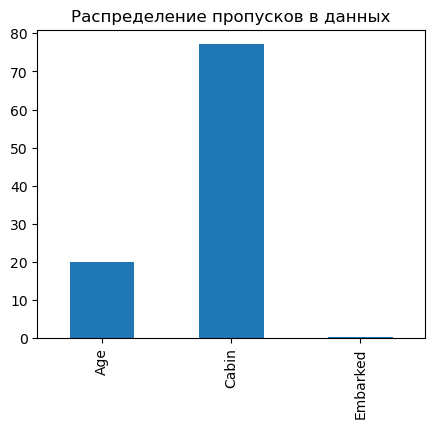

In [4]:
# Выведем информацию о пропусках
cols_null_percent = df.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0]
cols_with_null.plot(
    kind='bar',
    figsize=(5, 4),
    title='Распределение пропусков в данных'
);

In [5]:
# Можно увидеть, что 3 признака содержат пустые значения - Age, Cabin, Embarked,
# при чем Cabin имеет более 75% пропусков

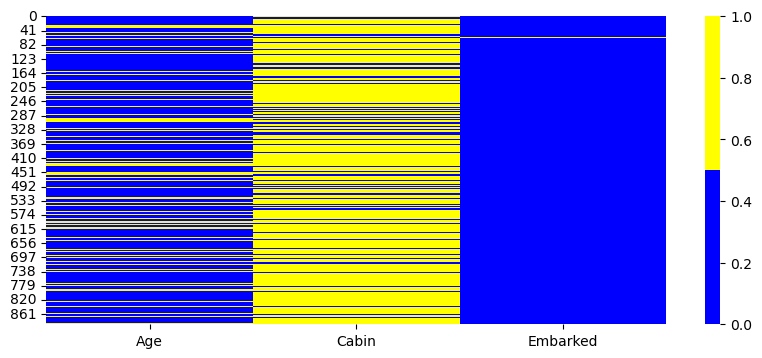

In [6]:
# И так очевидно, но ради упражнения посмотрим, как коррелируют пропуски в соответствующих признаках между собой
# на картинке heatmap
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    df[cols].isnull(),
    cmap=sns.color_palette(colors),
)

In [7]:
# Корреляции, ожидаемо, не видим

In [8]:
# В данном датасете логично принять за целевой признак - Survived, т.к. это результирующее событие
# Это бинарный признак, где 1 означает survived (выжил), а 0, соответственно, perished (погиб)

In [9]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

<AxesSubplot:title={'center':'Count (Survived)'}>

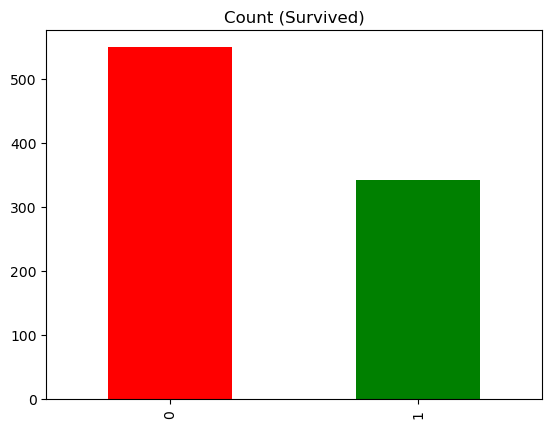

In [10]:
# А что у нас со сбалансированностью по признаку Survived?
df.Survived.value_counts().plot(
    kind='bar', 
    title='Count (Survived)', 
    color = ['r', 'g']
)

In [11]:
# Сбалансированнаять неидеальна, но соотношение составляет примерно 2:3, что является приемлемым соотношением для 
# поиска будущей модели, не прибегая к потере данных ради балансировки

In [12]:
# Посмотрим, какая картина по возрастным группам выживших и невыживших?

<AxesSubplot:xlabel='Age', ylabel='Count'>

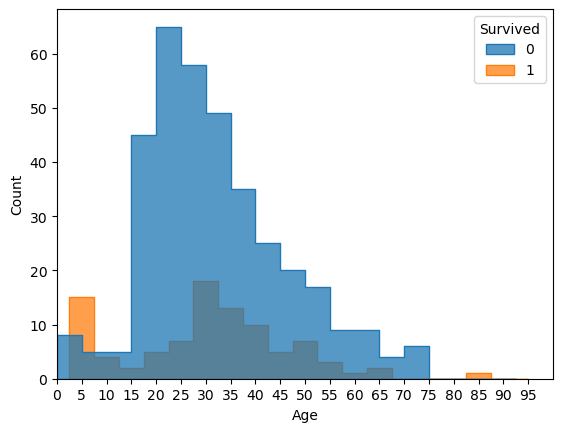

In [13]:
# Мужчины

fig, ax = plt.subplots()
ax.set_xlim(0, 100)
ax.set_xticks(range(0,100,5))
sns.histplot(x=df[df.Sex == 'male'].Age.dropna(), 
             hue=df.Survived, 
             data=df[df.Sex == 'male'].Age.dropna(), 
             element='step', 
             multiple='dodge', 
             bins=range(0, 100, 5))

In [14]:
df[(df.Sex == 'male') & (df.Survived == 0)].Pclass.value_counts(normalize=True)

3    0.641026
2    0.194444
1    0.164530
Name: Pclass, dtype: float64

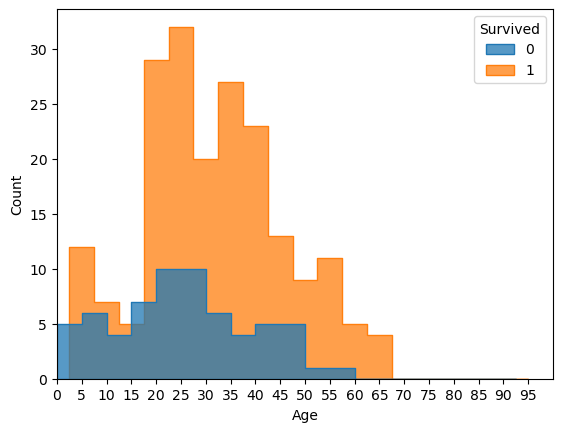

In [15]:
# Женщины
fig, ax = plt.subplots()
ax.set_xlim(0,100)
ax.set_xticks(range(0,100,5))
sns.histplot(x=df[df.Sex == 'female'].Age, 
             hue=df.Survived, 
             data=df[df.Sex == 'female'].Age.dropna(), 
             element='step', 
             multiple='dodge', 
             bins=range(0, 100, 5))
plt.show()


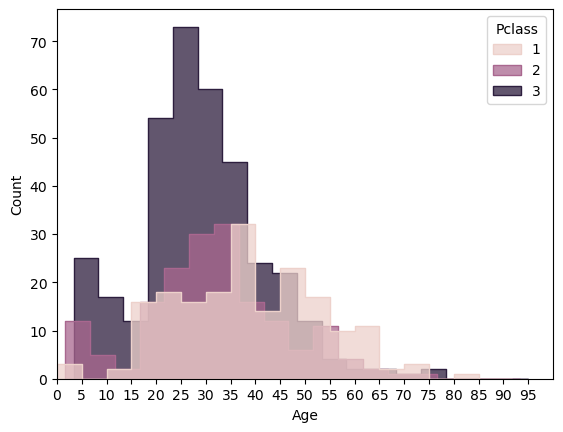

In [16]:
# Посмотрим как пассажиры разбиты по классам

fig, ax = plt.subplots()
ax.set_xlim(0,100)
ax.set_xticks(range(0,100,5))
sns.histplot(x=df.Age, 
             hue=df.Pclass, 
             data=df, 
             element='step', 
             multiple='dodge', 
             bins=range(0, 100, 5))
plt.show()

In [17]:
# Посмотрим статистику с разбивкой по классам
df1 = df[df.Pclass == 1]
df2 = df[df.Pclass == 2]
df3 = df[df.Pclass == 3]

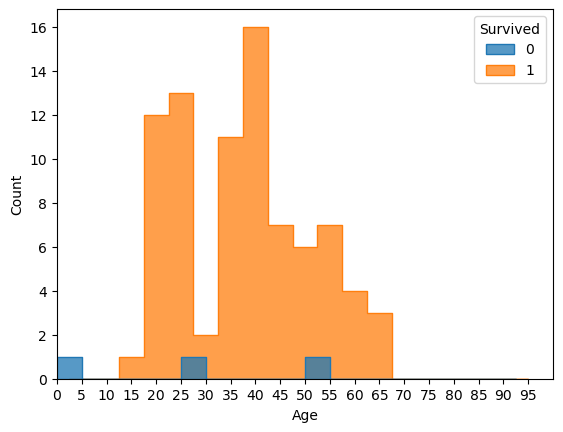

In [18]:
# Просматривая отношение выживших к погибшим в каждом классе, можно зафиксировать следующие наблюдения:
#     1. Принцип "женщины и дети" явно подтверждается данной выборкой
#     2. Почти все дети 1го и 2го класса были спасены (в данной выборке)
#     3. Женщины и дети 3го класса пострадали более всего из-за нехватки спасательных шлюпок и других причин, которые были 
# не применимы к пассажирам 1го и 2го классов
#     4. У мужчин 1 класса шансы на спасение кратно превышают шансы мужчин 2го и 3го классов, что подчеркивает силу признака Pclass

fig, ax = plt.subplots()
ax.set_xlim(0,100)
ax.set_xticks(range(0,100,5))
# sns.histplot(x=df1[df1.Sex == 'male'].Age, hue=df1.Survived, data=df1[df1.Sex == 'male'], 
# sns.histplot(x=df2[df2.Sex == 'male'].Age, hue=df2.Survived, data=df2[df2.Sex == 'male'], 
# sns.histplot(x=df3[df3.Sex == 'male'].Age, hue=df3.Survived, data=df3[df3.Sex == 'male'], 
sns.histplot(x=df1[df1.Sex == 'female'].Age, hue=df1.Survived, data=df1[df1.Sex == 'female'], 
# sns.histplot(x=df2[df2.Sex == 'female'].Age, hue=df2.Survived, data=df2[df2.Sex == 'female'], 
# sns.histplot(x=df3[df3.Sex == 'female'].Age, hue=df3.Survived, data=df3[df3.Sex == 'female'], 
             element='step', multiple='dodge', bins=range(0, 100, 5))
plt.show()

In [19]:
# В итоге приходим к промежуточному выводу: что на наш целевой признак оказывают заметное влияние следующие признаки:
#     - возрастная категория (достаточно классифицировать на - ребенок и взрослый)
#     - класс пассажира 

In [20]:
# Мы убедились, что признак Age имеет ограниченное влияние на наш целевой признак (Survived), но у этого признака 177 пустых 
# значений из 891 записей, а это около 20% данных
# Т.к. наша выборка достаточно мала, необходимо попытаться найти возможность сохранить такие записи и сделать это можно,
# оценив обращение в признаке Name (такие как Mr / Mrs / Dr / Master)

In [21]:
child_age = 16
df.loc[df.Age < child_age, 'Age'] = 0    # дети
df.loc[df.Age >= child_age, 'Age'] = 1    # взрослые

In [22]:
# Выведем детей-мальчиков (обращение Master), у которых признак Adult (Age) пустое значение
df[(df.Age.isna()) & (df.Sex == 'male') & (df.Name.str.contains('Master.'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
176,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C


In [23]:
# избавимся от NaN для мальчиков 
df.loc[(df.Age.isna()) & (df.Sex == 'male') & (df.Name.str.contains('Master.')), 'Age'] = 0
df.loc[[65, 159, 176, 709]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,66,1,3,"Moubarek, Master. Gerios",male,0.0,1,1,2661,15.2458,NaN,C
159,160,0,3,"Sage, Master. Thomas Henry",male,0.0,8,2,CA. 2343,69.5500,NaN,S
176,177,0,3,"Lefebre, Master. Henry Forbes",male,0.0,3,1,4133,25.4667,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,0.0,1,1,2661,15.2458,NaN,C


In [24]:
# избавимся от NaN для взрослых мужчин 
df.loc[(df.Age.isna()) & (df.Sex == 'male') & (df.Name.str.contains('Mr.')), 'Age'] = 1

In [25]:
df[(df.Age.isna()) & (df.Sex == 'male')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,NaN,C


In [26]:
# Очевидно, что обращение "Доктор" (Dr.) тоже относится к взрослому
df.loc[(df.Age.isna()) & (df.Name.str.contains('Dr.')), 'Age'] = 1

In [27]:
# Что касается девочек и женщин, то возраст играл наименьшую роль по той же причине (принцип - спасаем женщин и детей),
# поэтому мы можем присвоить значение 1 для записей, где видим в имени обращение 'Mrs' и 0 для 'Miss' или 'Ms'
df.loc[(df.Age.isna()) & (df.Sex == 'female') & (df.Name.str.contains('Miss.' or 'Ms.')), 'Age'] = 0
df.loc[(df.Age.isna()) & (df.Sex == 'female') & (df.Name.str.contains('Mrs.')), 'Age'] = 1

In [28]:
# Итак, мы полностью избавились от пустых значений в признаке Age, переведя вещественные значения в бинарный вид (0, 1)
df[df.Age.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [30]:
# Изучение обращений (титулов) в выборке обнаружило следующее любопытное наблюдение:
# Все 6 священников (обращение Rev.) путешествовали 2ым классом и погибли. Даже, если это совпадение, то такой исход был бы ожидаемым, по понятным причинам.
df[df.Name.str.contains('Rev.')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,1.0,0,0,244310,13.000,NaN,S
150,151,0,2,"Bateman, Rev. Robert James",male,1.0,0,0,S.O.P. 1166,12.525,NaN,S
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,1.0,1,0,244252,26.000,NaN,S
626,627,0,2,"Kirkland, Rev. Charles Leonard",male,1.0,0,0,219533,12.350,NaN,Q
848,849,0,2,"Harper, Rev. John",male,1.0,0,1,248727,33.000,NaN,S
886,887,0,2,"Montvila, Rev. Juozas",male,1.0,0,0,211536,13.000,NaN,S


In [31]:
# Общая статистика выживших пассажиров 2го класса практически исключает предположение о том, что статистика по священникам 
# была совпадением, для которых соотношение выживших к погибшим было 0 к 6.
# В масштабах всех пассажиров 2го класса, такое соотношение составляет 87 к 97 (0.8969072164948454)
df[(df.Pclass == 2) & (df.Survived == 1)].shape[0] / df[(df.Pclass == 2) & (df.Survived == 0)].shape[0]

0.8969072164948454

In [32]:
# Принимаем решение добавить новый бинарный признак Rev
df.loc[df.Name.str.contains('Rev.'), 'Rev'] = 1
df.loc[df.Name.str.contains('Rev.') == False, 'Rev'] = 0

In [33]:
# Избавимся от признаков, которые не влияют на выживаемость. Из Name мы "выжали" по-максимуму, этот признак нам более не нужен.
# К сожалению, в выборке нельзя идентифицировать команду корабля (кроме капитана), поэтому ради одного человека заводить новый 
# признак нет особоко смысла
df = df.drop(['PassengerId', 'Name', 'Cabin', 'Embarked', 'Ticket', 'Fare'], axis=1)

In [34]:
# Переведем в цифру признак Sex
df.loc[df.Sex == 'male', 'Sex'] = 0
df.loc[df.Sex == 'female', 'Sex'] = 1

In [35]:
# Избавимся от колонки-категории Pclass
df.loc[df.Pclass == 1, 'Pclass'] = 'High'
df.loc[df.Pclass == 2, 'Pclass'] = 'Medium'
df.loc[df.Pclass == 3, 'Pclass'] = 'Low'
df = pd.concat((df, pd.get_dummies(df['Pclass'])), axis=1)
df = df.drop(['Pclass'], axis=1)

In [36]:
df.Age = df.Age.astype(int)
df.Rev = df.Rev.astype(int)

# А вот и наши подготовленные данные выборки. Напомню результирующие значения колонок:
# Survived - наша цель (выжил / погиб)
# Sex - пол
# Age - возрастная категория (0 - ребенок / 1 - взрослый)
# SibSp & Parch - количество близких родственников, путешествующих вместе
# Rev - титул "преподобных" (в нашей выборке они все погибли, предположительно, из-за чувств самопожертвования ради спасения людей)
# High / Medium / Low - класс обслуживания
df

,Survived,Sex,Age,Rev,High,Low,Medium
0,0,0,1,0,0,1,0
1,1,1,1,0,1,0,0
2,1,1,1,0,0,1,0
3,1,1,1,0,1,0,0
4,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...
886,0,0,1,1,0,0,1
887,1,1,1,0,1,0,0
888,0,1,0,0,0,1,0
889,1,0,1,0,1,0,0


In [37]:
# Несколько изменим нашу try_model функцию, чтобы она помогла вычислить средние и сформировать нам таблицу с результатами

def try_model(model, X_train, y_train, X_test, y_test, plot_flag=False, model_params=None):
    res = {}
    model_name = model.__name__
    res[model_name] = list()
    res[model_name].append([])
    res[model_name].append([])
    res[model_name].append([])
    res[model_name].append([])
    res[model_name].append([])
    res[model_name].append([])
   
    if model_params is None:
        model_params = dict()

    pipeline = make_pipeline(StandardScaler(), model(**model_params))

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    res[model_name][0].append(accuracy_score(y_test, y_pred))
    res[model_name][1].append(precision_score(y_test, y_pred))
    res[model_name][2].append(recall_score(y_test, y_pred))
    res[model_name][3].append(f1_score(y_test, y_pred))
    res[model_name][4].append(roc_auc_score(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
    res[model_name][5].append(auc(fpr, tpr))
    
    if plot_flag:
        plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
        plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
        plt.legend()

        ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

    return res

In [38]:
# Определим наши исходные датасеты x & y
x = df[['Sex', 'Age', 'SibSp', 'Parch', 'High', 'Medium', 'Low', 'Rev']]

y = df['Survived']

In [39]:
# Сформируем train & test выборки, зададим список моделей, запустим нашу try_model функцию для каждой из них n-раз,
# сформируем наш сводный отчет в rep_df
import warnings

f1_roc_auc = []
models = [LogisticRegression, SVC, GaussianNB, KNeighborsClassifier, DecisionTreeClassifier, MLPClassifier]
idx = ['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'roc_auc_score', 'auc']
n = 200

def dic_join(d1, d2):
    if d1 == {}:
        return d2
    else:
        for k in d1.keys():
            for i in range(6):
                d1[k][i] = d1[k][i] + d2[k][i]
        return d1
    
consolidic = {}
for i in range(1, n):
    results = {} 
    x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.25, random_state=i, stratify=y)

    for m in models:
        if m == SVC:
            results.update(try_model(m, x_train, y_train, x_test, y_test, model_params=dict(
                kernel='linear',
                probability=True
            )))
        else:
            # results.update(try_model(m, x_train, y_train, x_test, y_test, model_params=None))
            def kill_warning():
                results.update(try_model(m, x_train, y_train, x_test, y_test, model_params=None))
                warnings.warn("deprecated", DeprecationWarning)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                kill_warning()
    consolidic = dic_join(consolidic, results)  


In [40]:
consolidic_avg = {}
for k in consolidic.keys():
    consolidic_avg[k] = [sum(consolidic[k][i]) / len(consolidic[k][i]) for i in range(6)]
rep_df = pd.DataFrame(data=consolidic_avg, index=idx)

In [41]:
# Выведем нашу отчетную таблицу
rep_df.style.background_gradient(axis=1)

,LogisticRegression,SVC,GaussianNB,KNeighborsClassifier,DecisionTreeClassifier,MLPClassifier
accuracy_score,0.790612,0.788855,0.392118,0.781463,0.799220,0.800009
precision_score,0.777188,0.746344,0.388170,0.783217,0.849551,0.844119
recall_score,0.655545,0.687332,1.000000,0.643158,0.592381,0.601613
f1_score,0.706012,0.714747,0.559251,0.692549,0.692668,0.696565
roc_auc_score,0.765472,0.769958,0.505264,0.755720,0.760721,0.763081
auc,0.849134,0.808231,0.841073,0.823780,0.858397,0.857247


In [42]:
# Как видно из таблицы выше, по всем метрикам наилучший результат продемонстрировала модель MLPClassifier 

{'MLPClassifier': [[0.820627802690583],
  [0.8833333333333333],
  [0.6162790697674418],
  [0.7260273972602739],
  [0.7825920896282464],
  [0.8738754031573586]]}

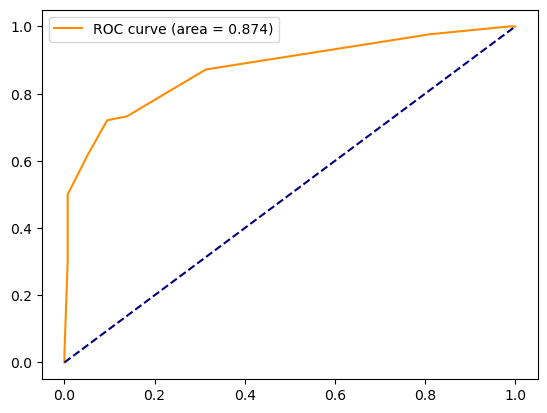

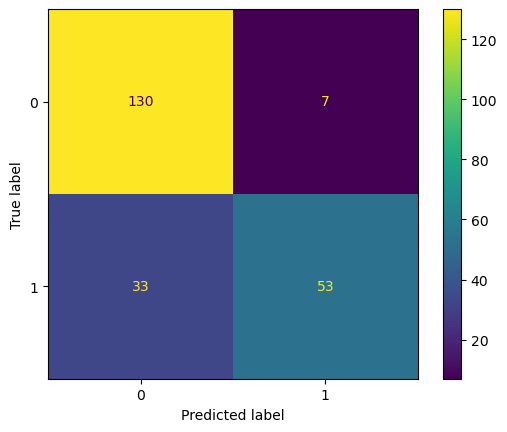

In [43]:
# Выведем картинки для лучшей модели
try_model(MLPClassifier, x_train, y_train, x_test, y_test, plot_flag=True, model_params=None)

Text(0.5, 1.0, 'AUC distribution')

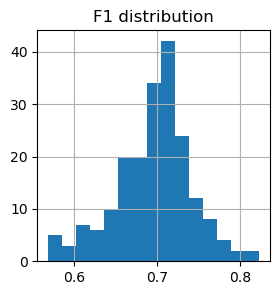

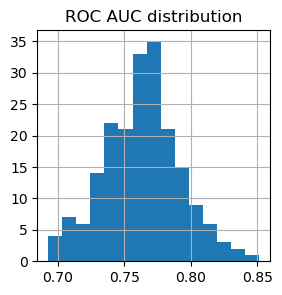

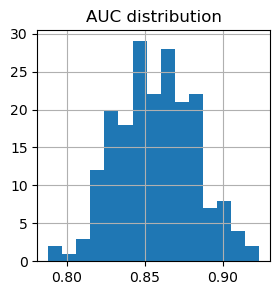

In [44]:
# Убедимся, что наши метрики распределяются нормально
f1 = {}
f1['MLPClassifier'] = consolidic['MLPClassifier'][3]
roc_auc = {}
roc_auc['MLPClassifier'] = consolidic['MLPClassifier'][4]
auc = {}
auc['MLPClassifier'] = consolidic['MLPClassifier'][5]

f1_df = pd.DataFrame(data=f1)
roc_auc_df = pd.DataFrame(data=roc_auc)
auc_df = pd.DataFrame(data=auc)

f1_df.hist(bins=15, figsize = (3,3))
plt.title('F1 distribution')

roc_auc_df.hist(bins=15, figsize = (3,3))
plt.title('ROC AUC distribution')

auc_df.hist(bins=15, figsize = (3,3))
plt.title('AUC distribution')
